In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [306]:
Customers = pd.read_csv('CleanedDataSets/customers_c.csv')

In [237]:
features = Customers[[
    'new_customer',
    'total_orders',
    'review_score',
    'total_price',
    'average_frequency'
]]

In [240]:
# Scale all the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [241]:
scaled_features

array([[-0.45199676, -0.16236828, -0.05135266, -0.08522118,  0.17685805],
       [-0.45199676, -0.16236828,  0.68724662,  0.72976539,  0.17685805],
       [-0.45199676, -0.16236828,  0.68724662, -0.03829496,  0.17685805],
       ...,
       [-0.45199676, -0.16236828, -2.26715052, -0.47769893,  0.17685805],
       [-0.45199676, -0.16236828,  0.68724662,  2.35269527,  0.17685805],
       [-0.45199676, -0.16236828,  0.68724662, -0.6257801 ,  0.17685805]])

In [242]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

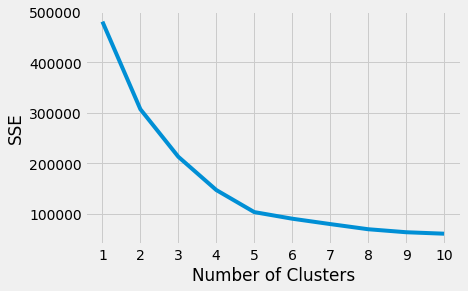

In [243]:
# Create the elbow chart
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [244]:
# Create the K means clustering for k=5
kmeans = KMeans(
  init="random",
  n_clusters=5,
  n_init=10,
  max_iter=300,
  random_state=42
)
kmeans.fit(scaled_features)
sse.append(kmeans.inertia_)

In [307]:
# Move cluster labels back into Customers dataset
Customers['cluster'] = kmeans.labels_

In [308]:
# Getting statistics between clusters and variables or interest:

In [309]:
# Initialize Empty cluster dataframe
clusters = {'cluster': [0,1,2,3,4]}
clusters = pd.DataFrame(data=clusters)

In [310]:
# Cluster Proportion
proportion = pd.DataFrame(Customers.groupby(by=['cluster'])['cluster'].count())
total_customers = Customers.customer_unique_id.count()
proportion.rename(columns={'cluster':'proportion'},inplace=True)
proportion.proportion = proportion.proportion / total_customers
porportion = proportion.reset_index()
clusters = clusters.set_index('cluster').join(proportion.reset_index().set_index('cluster')).reset_index()

In [311]:
# New Customer Proportion
new_customer = pd.DataFrame(Customers.loc[Customers.new_customer == 1].groupby(by='cluster')['new_customer'].count())
new_customer = new_customer.reset_index()
new_customer['total_customers'] = pd.DataFrame(Customers.groupby(by='cluster')['new_customer'].count())
new_customer['new_customer_proportion'] = new_customer['new_customer'] / new_customer['total_customers']
clusters = clusters.set_index('cluster').join(new_customer[['cluster','new_customer_proportion']].reset_index().set_index('cluster')).reset_index()
clusters.pop('index')
clusters['new_customer_proportion'] = clusters['new_customer_proportion'].fillna(value=0)

In [312]:
# Came Back Proportion
came_back = pd.DataFrame(Customers.loc[Customers.came_back == 1].groupby(by='cluster')['came_back'].count())
came_back = came_back.reset_index()
came_back['total_customers'] = pd.DataFrame(Customers.groupby(by='cluster')['came_back'].count())
came_back['came_back_proportion'] = came_back['came_back'] / came_back['total_customers']

clusters = clusters.set_index('cluster').join(came_back[['cluster','came_back_proportion']].reset_index().set_index('cluster')).reset_index()
clusters.pop('index')
clusters['came_back_proportion'] = clusters['came_back_proportion'].fillna(value=0)

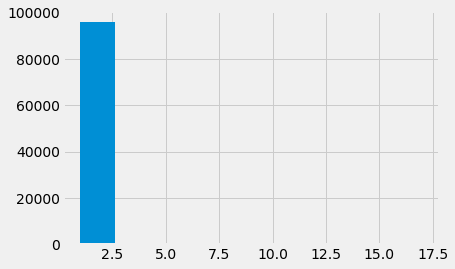

In [313]:
Customers['total_orders'].hist()

In [314]:
# Average Total Orders
average_total_orders = pd.DataFrame(Customers.groupby(by='cluster')['total_orders'].mean().reset_index())
average_total_orders.rename(columns={'total_orders':'average_total_orders'},inplace=True)
clusters = clusters.set_index('cluster').join(average_total_orders.set_index('cluster')).reset_index()

In [315]:
# Total Orders
total_orders = pd.DataFrame(Customers.groupby(by='cluster')['total_orders'].sum().reset_index())
clusters = clusters.set_index('cluster').join(total_orders.set_index('cluster')).reset_index()

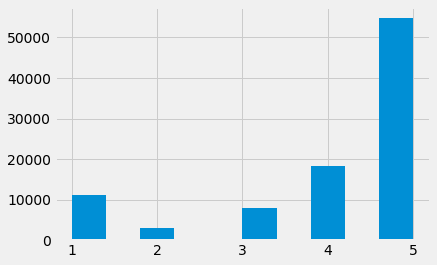

In [316]:
Customers['review_score'].hist()

In [317]:
# Average Review Score
review_score = pd.DataFrame(Customers.groupby(by='cluster')['review_score'].mean().reset_index())
clusters = clusters.set_index('cluster').join(review_score.set_index('cluster')).reset_index()

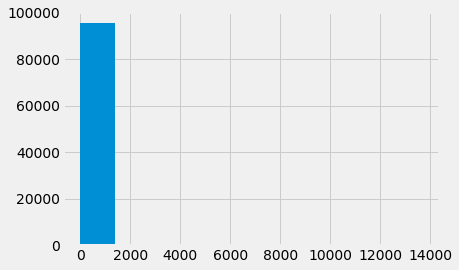

In [318]:
Customers['total_price'].hist()

In [319]:
# Average Total Price
average_total_price = pd.DataFrame(Customers.groupby(by='cluster')['total_price'].mean().reset_index())
average_total_price.rename(columns={'total_price':'average_total_price'},inplace=True)
clusters = clusters.set_index('cluster').join(average_total_price.set_index('cluster')).reset_index()

In [320]:
# Total Price
total_price = pd.DataFrame(Customers.groupby(by='cluster')['total_price'].sum().reset_index())
clusters = clusters.set_index('cluster').join(total_price.set_index('cluster')).reset_index()

In [321]:
# Most Common Item <NOT USED>
most_common_item = pd.DataFrame(Customers.groupby(by='cluster')['favorite_product'].agg(lambda x: pd.Series.mode(x)[0]))
most_common_item

,favorite_product
cluster,
0,watches_gifts
1,bed_bath_table
2,health_beauty
3,bed_bath_table
4,bed_bath_table


In [322]:
# Transpose the cluster table so Clusters are on top.
cluster_info = clusters.T
clusters.set_index('cluster')

,proportion,new_customer_proportion,came_back_proportion,average_total_orders,total_orders,review_score,average_total_price,total_price
cluster,,,,,,,,
0,0.021083,0.137710,0.003455,1.003949,2034,3.924729,1274.203238,2581535.76
1,0.592480,0.000000,0.000000,1.000000,56935,4.741389,133.364429,7593103.76
2,0.162920,0.274980,0.000000,1.000000,15656,4.269162,139.563174,2185001.05
3,0.192401,0.000000,0.000000,1.000000,18489,1.843096,148.119737,2738585.81
4,0.031115,0.012519,0.052516,2.116054,6327,4.096246,304.563793,910645.74


In [323]:
# Save to clean Full customers with clusters
Customers.to_csv('CleanedDatasets/CustomersClustering.csv')

# Save to clean customers clusters DS
cluster_info.to_csv('CleanedDatasets/cluster_customers.csv')

Text(0, 0.5, 'pc2')

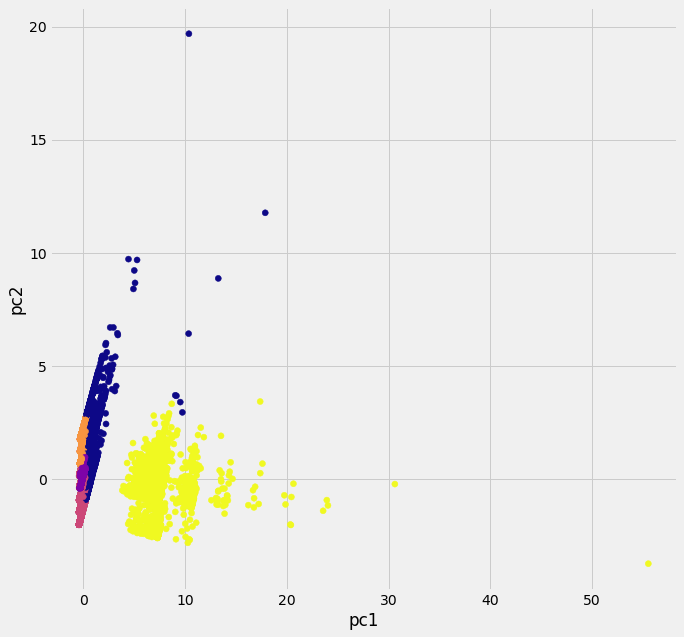

In [324]:
pca = PCA(n_components=2)
pca.fit(scaled_features)
pca
x = pca.transform(scaled_features)
x.shape
pca.components_
plt.figure(figsize=(10,10))
plt.scatter(x[:,0],x[:,1],c=Customers['cluster'],cmap='plasma',label=Customers['cluster'])
plt.xlabel('pc1')
plt.ylabel('pc2')